In [2]:
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal
import xarray as xr
from scipy.io import loadmat
from scipy.interpolate import interp2d, NearestNDInterpolator

import os
os.getcwd()

%cd /g/data/p66/ars599/EAE_Lecture/Ocean/

/g/data/p66/ars599/EAE_Lecture/Ocean


In [3]:
idir = '/g/data/p66/ars599/work_eae/'
filenames = [idir+'uo_Omon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912_v10.nc',
            idir+'vo_Omon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912_v10.nc',
            idir+'wo_Omon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912_v10.nc',
            idir+'thetao_Omon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912_v10.nc']

file_list = []

for filename in filenames:
    ds = xr.open_dataset(filename)
    file_list.append(ds)


In [4]:
# Assuming your dataset is named ds - uo
ds = file_list[0]

# Assuming uo is the uo variable from your xarray.Dataset (ds)
uo = ds.uo

In [5]:
# Assuming your dataset is named ds - vo
ds = file_list[1]

# Assuming vo is the vo variable from your xarray.Dataset (ds)
vo = ds.vo

In [6]:
# Assuming your dataset is named ds - theta
ds = file_list[3]

# Assuming vo is the vo variable from your xarray.Dataset (ds)
theta = ds.thetao

In [7]:
# Assuming your dataset is named ds
ds = file_list[2]

# Assuming vo is the vo variable from your xarray.Dataset (ds)
wo = ds.wo

## Testing different methods

In [8]:
# Method 1
# Calculate the gradient of velocity with respect to longitude
tNum, lNum, jNum, iNum = theta.shape
dT_dlon = theta.differentiate('i')  # First-order difference along the longitude dimension
dT_dlat = theta.differentiate('j')  # First-order difference along the latidue dimension
dT_dlev = theta.differentiate('lev')  # First-order difference along the latidue dimension


In [9]:
# Method 2
gradT_x = theta * 0
gradT_y = theta * 0
gradT_lon = theta * 0
gradT_lat = theta * 0
for l in range(lNum): # convert from degree
    for m in range(tNum):
        gradT_y[m, l, :, :], gradT_x[m, l, :, :] = np.gradient(theta[m,l,:,:], -np.deg2rad(.75), np.deg2rad(.75))
for l in range(lNum): # keep as degree
    for m in range(tNum):
        gradT_lat[m, l, :, :], gradT_lon[m, l, :, :] = np.gradient(theta[m,l,:,:])



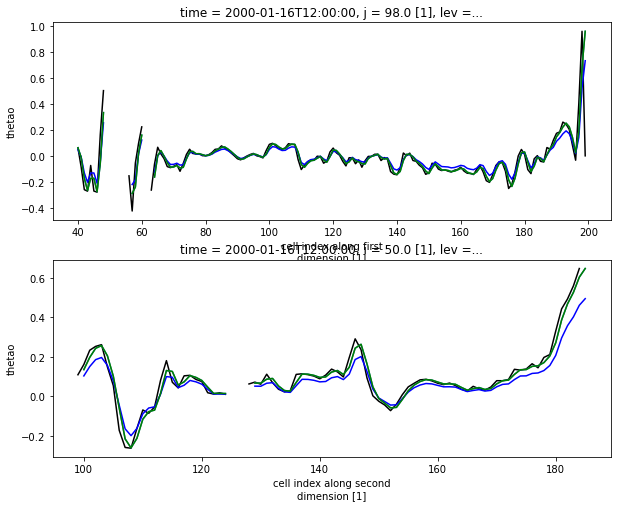

In [10]:
# Shift the theta array by one step along the last axis
theta_t = np.roll(theta, shift=-1, axis=0)
theta_i = np.roll(theta, shift=-1, axis=-1)
theta_j = np.roll(theta, shift=-1, axis=-2)
theta_lev = np.roll(theta, shift=-1, axis=-3)

# Calculate the derivative using array subtraction
dTdlon = theta - theta_i # in this case this will be - dTdlon
dTdlat = theta - theta_j
dTdlev = theta - theta_lev

# Set the last column of dTdlon to 0 since there's no valid value for the derivative there
dTdlon[..., -1] = 0


# now focus on the plot
fig = plt.subplots( figsize=(10, 8) )
plt.subplot(211)
(dTdlon[0,0,10,:]*-1).plot(c='k')
dT_dlon[0,0,10,:].plot()
(gradT_x[0,0,10,:]* 1e-2 ).plot(c='b') # 100 why??
gradT_lon[0,0,10,:].plot(c='g')

plt.subplot(212)
(dTdlat[0,0,:,10]).plot(c='k')
(dT_dlat[0,0,:,10]*-1).plot()
(gradT_y[0,0,:,10]* 1e-2).plot(c='b')
(gradT_lat[0,0,:,10]*-1).plot(c='g')


In [29]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the colors for the colormap
colors = [
    (0.0000000e+00, 0.0000000e+00, 1.0000000e+00),
    (1.0000000e-01, 1.0000000e-01, 1.0000000e+00),
    (2.0000000e-01, 2.0000000e-01, 1.0000000e+00),
    (3.0000000e-01, 3.0000000e-01, 1.0000000e+00),
    (4.0000000e-01, 4.0000000e-01, 1.0000000e+00),
    (5.0000000e-01, 5.0000000e-01, 1.0000000e+00),
    (6.0000000e-01, 6.0000000e-01, 1.0000000e+00),
    (7.0000000e-01, 7.0000000e-01, 1.0000000e+00),
    (8.0000000e-01, 8.0000000e-01, 1.0000000e+00),
    (9.0000000e-01, 9.0000000e-01, 1.0000000e+00),
    (1.0000000e+00, 1.0000000e+00, 1.0000000e+00),
    (1.0000000e+00, 9.0000000e-01, 9.0000000e-01),
    (1.0000000e+00, 8.0000000e-01, 8.0000000e-01),
    (1.0000000e+00, 7.0000000e-01, 7.0000000e-01),
    (1.0000000e+00, 6.0000000e-01, 6.0000000e-01),
    (1.0000000e+00, 5.0000000e-01, 5.0000000e-01),
    (1.0000000e+00, 4.0000000e-01, 4.0000000e-01),
    (1.0000000e+00, 3.0000000e-01, 3.0000000e-01),
    (1.0000000e+00, 2.0000000e-01, 2.0000000e-01),
    (1.0000000e+00, 1.0000000e-01, 1.0000000e-01),
    (1.0000000e+00, 0.0000000e+00, 0.0000000e+00)
]

# Create the colormap
shayne_cmap = LinearSegmentedColormap.from_list("shayne_cmap", colors)


In [103]:
import numpy as np

def haversine_distance(dlat, dlon):
    # Radius of the Earth in kilometers
    R = 6371000

    # Convert latitude and longitude differences from degrees to radians
    dlat = np.radians(dlat)
    dlon = np.radians(dlon)

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(dlat) * np.cos(dlat) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Calculate the distance in meters
    distance = R * c * 1.0  # Convert to meters
    return distance


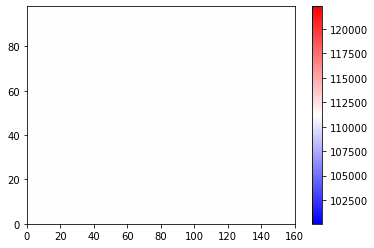

In [166]:
# Example usage with dlat and dlon as differences
# Calculate distances from a reference point to a grid of points defined by dlat and dlon
lon = theta.longitude.values
lat = theta.latitude.values
lon_y, lon_x = np.gradient(lon)
lat_y, lat_x = np.gradient(lat)

dist_lon = haversine_distance(lon_x, lon_y)
dist_lat = haversine_distance(lat_x, lat_y)

plt.pcolor(dist_lon,cmap=shayne_cmap)# should be,vmin=1.e5,vmax=1.2e5)
plt.colorbar()

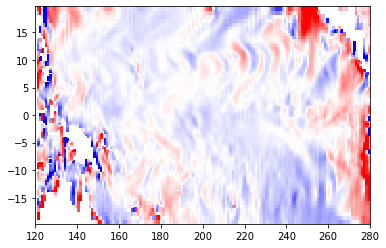

In [133]:
'''
https://gradsaddict.blogspot.com/2019/11/python-tutorial-temperature-advection.html
'''
theta_i = np.roll(theta, shift=1, axis=-1)
dTdlon = theta - theta_i # in this case this will be - dT_dlon
dTdlon[..., 0] = 0
plt.pcolor(dTdlon.longitude ,dTdlon.latitude,dTdlon[0,0,:,:],cmap=shayne_cmap,vmin=-.5,vmax=.5)

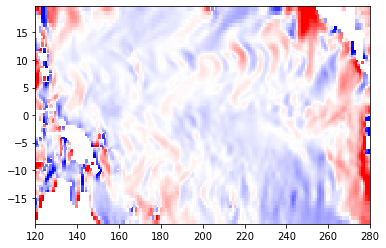

In [153]:
gradT_y[0, 0, :, :], gradT_x[0, 0, :, :] = np.gradient(theta[0,0,:,:], -1,1)
plt.pcolor(gradT_x.longitude ,gradT_x.latitude,gradT_x[0,0,:,:],cmap=shayne_cmap,vmin=-.5,vmax=.5)

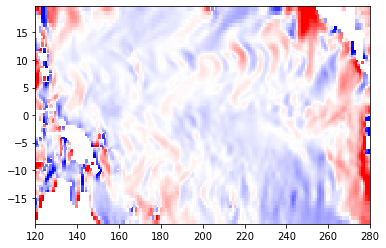

In [144]:
gradT_lat[0, 0, :, :], gradT_lon[0, 0, :, :] = np.gradient(theta[0,0,:,:])
plt.pcolor(gradT_lon.longitude ,gradT_lon.latitude,gradT_lon[0,0,:,:],cmap=shayne_cmap,vmin=-.5,vmax=.5)

In [140]:
'''
https://stackoverflow.com/questions/24633618/what-does-numpy-gradient-do
'''
y = np.array([1, 2, 4, 7, 11, 16], dtype=np.float)
print( np.gradient(y,0.1) )
print( np.gradient(y,0.5) )
print( np.gradient(y,1.0) )
print( np.gradient(y,1.5) )


[10. 15. 25. 35. 45. 50.]
[ 2.  3.  5.  7.  9. 10.]
[1.  1.5 2.5 3.5 4.5 5. ]
[0.66666667 1.         1.66666667 2.33333333 3.         3.33333333]


/jobfs/97912340.gadi-pbs/ipykernel_287698/4260439227.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.array([1, 2, 4, 7, 11, 16], dtype=np.float)


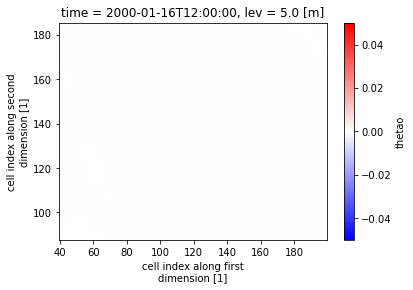

In [159]:
(gradT_x[0,0,:,:] - gradT_lon[0,0,:,:]).plot(cmap=shayne_cmap)

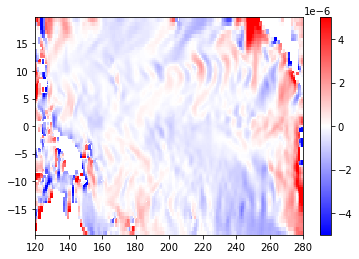

In [202]:
dTdx = gradT_x[0,0,:,:]/dist_lon
plt.pcolor(dTdx.longitude,dTdx.latitude,dTdx,cmap=shayne_cmap,vmin=-.5e-5,vmax=.5e-5)
plt.colorbar()

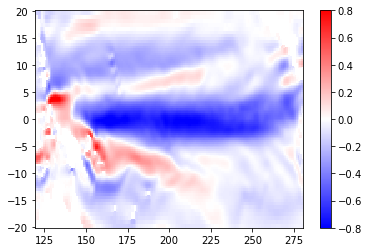

In [180]:
plt.pcolor(uo.longitude,uo.latitude,uo[0,0,:,:],cmap=shayne_cmap,vmin=-.8,vmax=.8)
plt.colorbar()

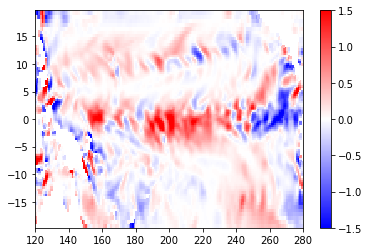

In [215]:
dTdxU = dTdx * uo[0,0,:,:]
dTdxU = dTdx*0 + dTdxU * 86400 * 30
plt.pcolor(dTdxU.longitude,dTdxU.latitude,dTdxU,cmap=shayne_cmap,vmin=-1.5,vmax=1.5)
plt.colorbar()